In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from autoencoder import Autoencoder_cnn
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet

import warnings
warnings.filterwarnings('ignore', category=Warning)

In [2]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=10)

In [3]:
model = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=4) 

Epoch:1, Loss:0.1752
Epoch:2, Loss:0.1650
Epoch:3, Loss:0.1602
Epoch:4, Loss:0.1565
Epoch:5, Loss:0.1535
Epoch:6, Loss:0.1517
Epoch:7, Loss:0.1491
Epoch:8, Loss:0.1478
Epoch:9, Loss:0.1468
Epoch:10, Loss:0.1455
Epoch:11, Loss:0.1437
Epoch:12, Loss:0.1418
Epoch:13, Loss:0.1413
Epoch:14, Loss:0.1391
Epoch:15, Loss:0.1381
Epoch:16, Loss:0.1371
Epoch:17, Loss:0.1358
Epoch:18, Loss:0.1345
Epoch:19, Loss:0.1341
Epoch:20, Loss:0.1334


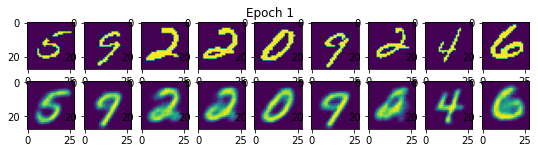

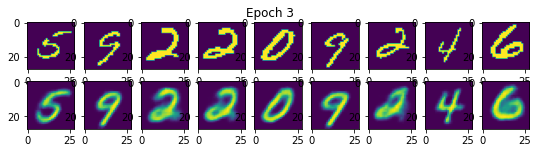

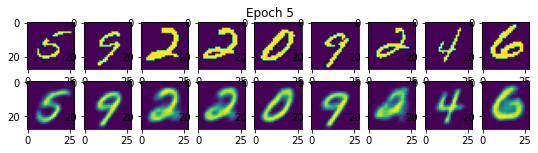

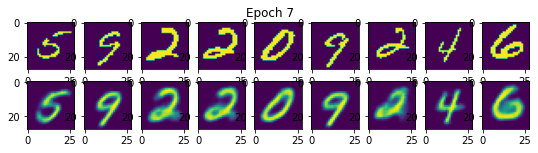

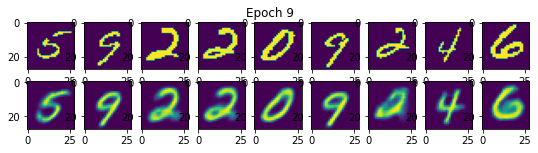

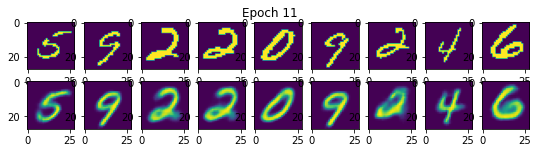

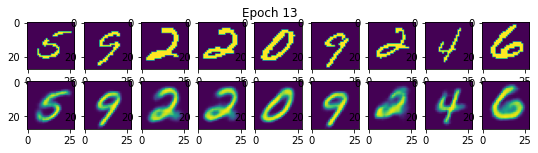

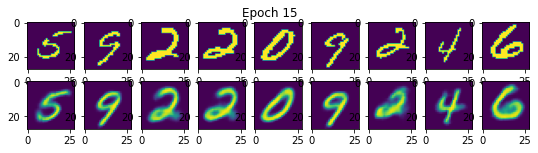

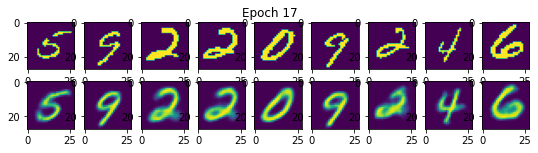

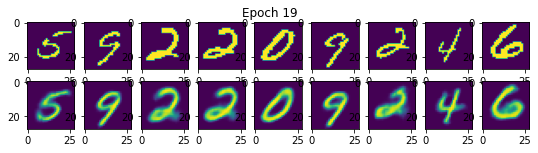

In [8]:
model.fit(gen, epochs=20, visualize=True)

In [11]:
model.save("autoencoders/model_1")

In [12]:
model = Autoencoder_cnn.load("autoencoders/model_1", n_channels=1, latent_dim=4)

## Test set

In [13]:
test_set = gen.get_full_data_set(training = False)
test_img, test_cls = test_set

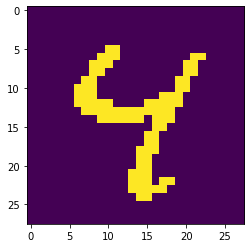

In [14]:
plt.imshow(test_img[6].astype(np.float32))

In [15]:
encoded = model.encode(test_img)

In [16]:
encoded.shape

torch.Size([10000, 4])

In [17]:
decoded = model.decode(encoded)

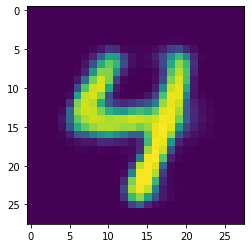

In [18]:
plt.imshow(decoded[6][0])

## Evaluation

In [19]:
net = VerificationNet("./models/verification_model")

In [20]:
decoded = decoded.squeeze(1)
decoded = np.expand_dims(decoded, axis=-1)

In [21]:
decoded.shape

(10000, 28, 28, 1)

In [22]:
net.predict(decoded)

313/313 [==============================] - 6s 18ms/step


(array([7., 2., 1., ..., 4., 5., 6.]),
 array([0.9998455 , 0.99962616, 0.99999797, ..., 0.99999404, 0.99763858,
        0.99999332]))

In [23]:
predictability, accuracy = net.check_predictability(data = decoded, correct_labels = test_cls)

313/313 [==============================] - 6s 18ms/step


In [24]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.9676. Accuracy is 0.9089


# Autoencoder as generative model

In [25]:
generated_imgs = model.generate(10)

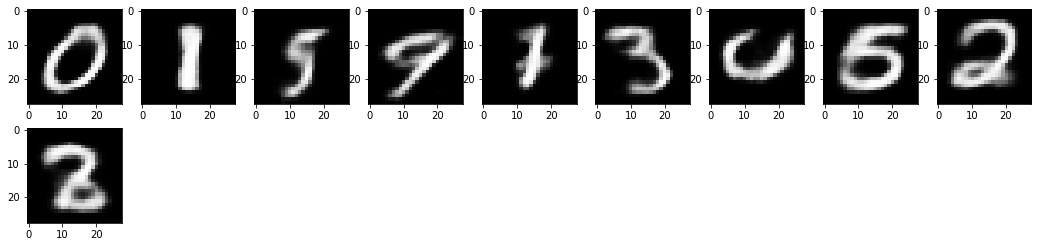

In [26]:
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float), cmap="gray") 

In [28]:
generated_imgs = model.generate(1000)
generated_imgs = generated_imgs.squeeze(1)
generated_imgs = np.expand_dims(generated_imgs, axis=-1)
net.check_predictability(data = generated_imgs)
coverage = net.check_class_coverage(data=generated_imgs, tolerance=.8)
print(f"Predictability is {predictability}. Coverage is {coverage}")

32/32 [==============================] - 1s 16ms/step
Predictability is 0.9676. Coverage is 1.0


# Autoencoder as anomaly detector

Epoch:1, Loss:0.2221
Epoch:2, Loss:0.2076
Epoch:3, Loss:0.1947
Epoch:4, Loss:0.1851
Epoch:5, Loss:0.1743
Epoch:6, Loss:0.1643
Epoch:7, Loss:0.1688
Epoch:8, Loss:0.1852
Epoch:9, Loss:0.1690
Epoch:10, Loss:0.1429
Epoch:11, Loss:0.1345
Epoch:12, Loss:0.1299
Epoch:13, Loss:0.1274
Epoch:14, Loss:0.1255
Epoch:15, Loss:0.1194
Epoch:16, Loss:0.1173


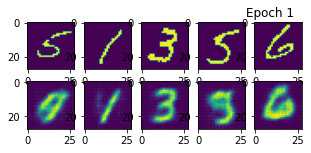

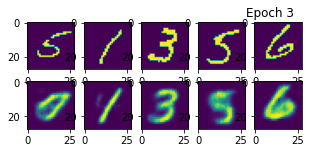

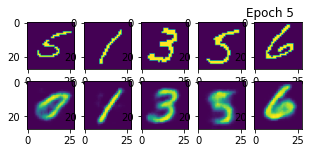

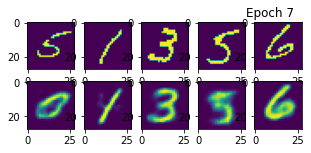

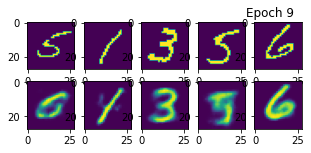

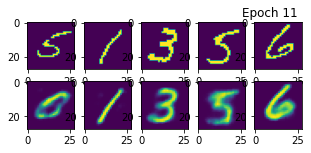

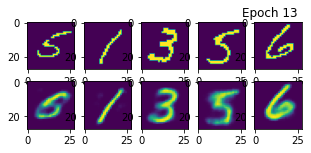

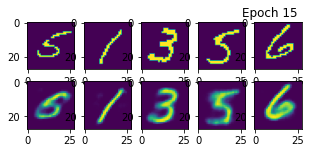

In [30]:
gen_miss = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=10)
model_miss = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=4)
model_miss.fit(gen_miss, epochs=16, visualize=True)

In [31]:
model_miss.save("autoencoders/model_miss")

In [32]:
model_miss = Autoencoder_cnn.load("autoencoders/model_miss", n_channels=1, latent_dim=4)

In [33]:
test_set = gen_miss.get_full_data_set(training = False)
test_img, test_cls = test_set

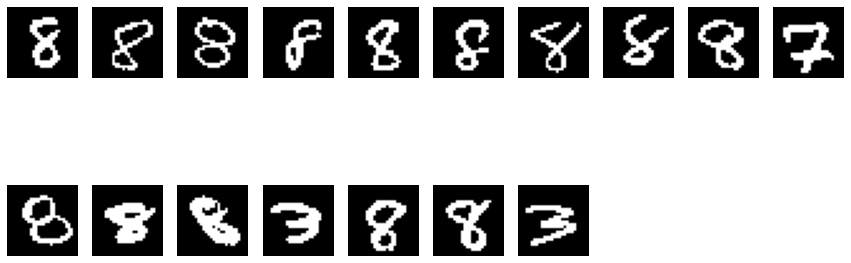

In [34]:
anomalies = model_miss.get_anomalious_imgs(test_img,test_cls,rule ="3-sigma",show_random=True, n_random=17)

### Evaluation of anomaly detector

In [35]:
anm_imgs, anm_cls = anomalies

In [36]:
TP = anm_cls[anm_cls==8].shape[0]/test_cls[test_cls==8].shape[0]
FP = anm_cls[anm_cls!=8].shape[0]/test_cls[test_cls!=8].shape[0]
#FN are 8-s in the dataset, but you failed to identify them.
FN = (test_cls[test_cls==8].shape[0]-anm_cls[anm_cls==8].shape[0])/test_cls[test_cls==8].shape[0]
print(f"TP = {TP:.4f}. FP={FP:.4f}. FN = {FN:.4f}")

TP = 0.1458. FP=0.0031. FN = 0.8542


## Stacked 

In [37]:
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

In [38]:
train_img, train_cls = gen.get_full_data_set(training = True)

In [39]:
train_img[0].shape

(28, 28, 3)

In [40]:
train_cls[2]

855

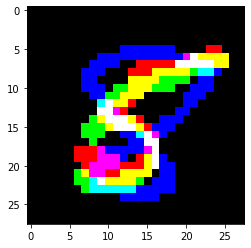

In [41]:
plt.imshow(train_img[2].astype(np.float))

Epoch:1, Loss:0.2297
Epoch:2, Loss:0.2194
Epoch:3, Loss:0.2046
Epoch:4, Loss:0.1752
Epoch:5, Loss:0.1482
Epoch:6, Loss:0.1320
Epoch:7, Loss:0.1219
Epoch:8, Loss:0.1163
Epoch:9, Loss:0.1118
Epoch:10, Loss:0.1082
Epoch:11, Loss:0.1054
Epoch:12, Loss:0.1033
Epoch:13, Loss:0.1017
Epoch:14, Loss:0.1001
Epoch:15, Loss:0.0986
Epoch:16, Loss:0.0973
Epoch:17, Loss:0.0961
Epoch:18, Loss:0.0951
Epoch:19, Loss:0.0944
Epoch:20, Loss:0.0936


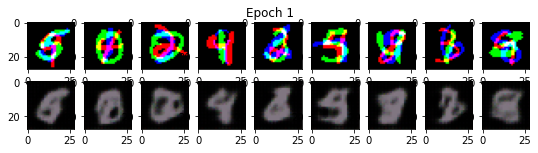

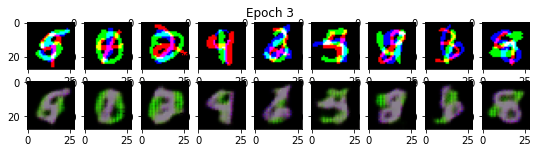

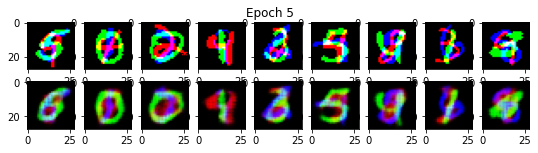

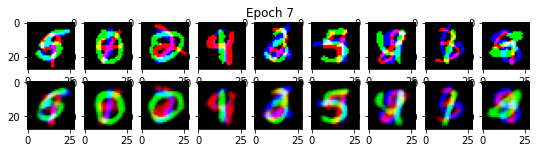

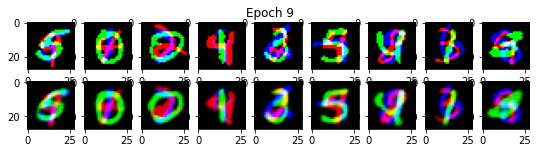

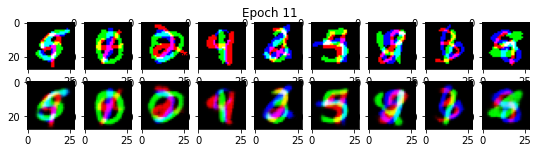

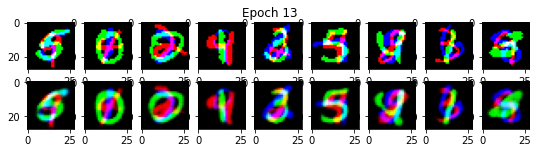

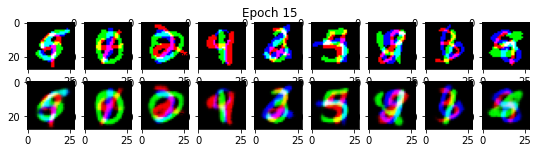

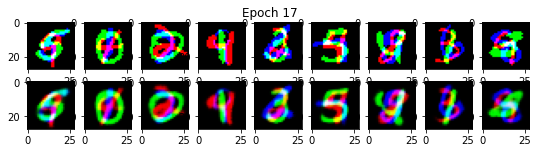

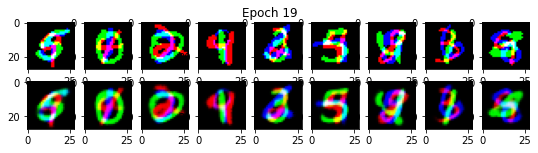

In [55]:
model_rgb = Autoencoder_cnn(n_channels=3,criterion=nn.BCELoss(), latent_dim=64)
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=32)
model_rgb.fit(gen, epochs=20, visualize=True)

In [56]:
model_rgb.save("autoencoders/model_rgb")

In [57]:
model_rgb = Autoencoder_cnn.load("autoencoders/model_rgb", n_channels=3, latent_dim=64)

## Test set

In [58]:
test_set = gen.get_full_data_set(training = False)

In [59]:
test_img, test_cls = test_set

In [60]:
encoded = model_rgb.encode(test_img)

In [61]:
decoded = model_rgb.decode(encoded)

In [62]:
predictability, accuracy = net.check_predictability(data = decoded.transpose((0,2,3,1)), correct_labels = test_cls, tolerance=0.5)

313/313 [==============================] - 6s 18ms/step


In [64]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.9517. Accuracy is 0.8328


# AE as generative model

In [65]:
encoded.shape

torch.Size([10000, 64])

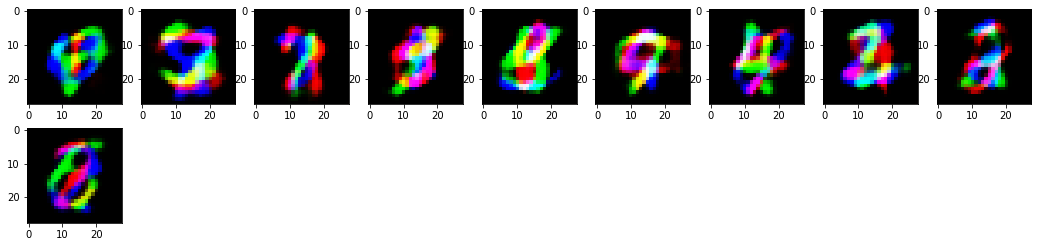

In [66]:
generated_imgs = model_rgb.generate(10)
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float)) 

In [67]:
generated_imgs = model_rgb.generate(1000)
net.check_predictability(data = generated_imgs.transpose((0,2,3,1)))
coverage = net.check_class_coverage(data=generated_imgs.transpose((0,2,3,1)), tolerance=.5)
print(f"Predictability is {predictability}. Coverage is {coverage}")

32/32 [==============================] - 1s 17ms/step
Predictability is 0.9517. Coverage is 0.272


# Stacked AE as Anomaly Detector

In [ ]:
gen_miss_stacked = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING, default_batch_size=10)
model_miss_stacked = Autoencoder_cnn(n_channels=3, criterion=nn.BCELoss(),latent_dim=64)
model_miss_stacked.fit(gen_miss_stacked, epochs=20, visualize=True)

Epoch:1, Loss:0.3024
Epoch:2, Loss:0.2949
Epoch:3, Loss:0.2871
Epoch:4, Loss:0.2677
Epoch:5, Loss:0.2585
Epoch:6, Loss:0.2453
Epoch:7, Loss:0.2683
Epoch:8, Loss:0.2511
Epoch:9, Loss:0.2388
Epoch:10, Loss:0.2219
Epoch:11, Loss:0.2074
Epoch:12, Loss:0.1829
Epoch:13, Loss:0.1723
Epoch:14, Loss:0.1693
Epoch:15, Loss:0.1641
Epoch:16, Loss:0.1553
Epoch:17, Loss:0.1527
Epoch:18, Loss:0.1565
Epoch:19, Loss:0.1542


In [ ]:
model_miss_stacked.save("autoencoders/model_miss_stacked")

In [ ]:
model_miss_stacked = Autoencoder_cnn.load("autoencoders/model_miss_stacked", n_channels=3, latent_dim=64)

In [ ]:
test_set = gen_miss_stacked.get_full_data_set(training = False)
test_img, test_cls = test_set

In [ ]:
anomalies = model_miss_stacked.get_anomalious_imgs(test_img,test_cls,rule ="2-sigma",show_random=True, n_random=30)

### Evaluation of anomaly detector


In [ ]:
anm_imgs, anm_cls = anomalies

In [ ]:
def contains_8(number):
    return (number // 100 == 8) | (number // 10 == 8) | (number %10 == 8)

In [ ]:
#anm_cls[contains_8(anm_cls)]

In [ ]:
TP = anm_cls[contains_8(anm_cls)].shape[0]/test_cls[contains_8(test_cls)].shape[0]
FN = (test_cls[contains_8(test_cls)].shape[0]-anm_cls[contains_8(anm_cls)].shape[0])/test_cls[contains_8(test_cls)].shape[0]
print(f"TP = {TP:.4f}. FN = {FN:.4f}")